This notebook continues from the data collection notebook. We now proceed with EDA and Modeling.

# Introduction

At the height of the pandemic in 2020, I decided to take advantage of my student status and subscribed for a discounted Spotify Premium, a popular music streaming service I still use today. Over time, I moved away from listening to other people's playlists and began curating my own, tailoring them to specific moods and genres. I have since created many playlists created a diverse list of music.

Now equipped with data science skills, I am curious to know: have I succeeded in making these playlists distinct from each other? Have I curated playlists with measurable differences? Can I use data science to determine if my playlists are truly unique from each other?

**Import relevant libraries**

In [5]:
# data processing
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data processing and distance measurements
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram

# more data processing
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# data modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# tree visualization
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Data Cleaning

Before proceeding with analysis, it's important to look at the features of the data and perform any cleaning that needs to be done.

In [8]:
df = pd.read_csv("Data.csv")

Determine if each playlist has enough songs.

In [10]:
df.groupby('playlist_id').size()

playlist_id
0JNVmbeDiae8wKkRuvOwz5      6
0hO1E26wNJOsdciAd1lGij     43
1YwEVgFzEneRuSSPV8AQIo      8
1jvHrIadN74e2I1reedjxW     18
45ufhPMPq9c1lb2Sij2ycX     10
4bhFPbVm2rVAmMzRTDzCVk     84
5HxObtpHZSwhtHNTXzhFVy     69
5yuMFyXsnTgOBkmdxkiuBq     32
699ZVOFCtrroaE09Fh0orf    152
6kFPBJrcGABQM5xDSmptVC      8
7thn2g61g86B0ClXZs5WvN      1
dtype: int64

Decide any playlists with over 10 (this number was arbitrary) will be kept.

In [12]:
df = df.groupby('playlist_id').filter(lambda group: len(group) > 10)

In [13]:
df.shape

(398, 29)

Check for missing values (I suspect there will be none, since we gathered this from the API).

In [15]:
df.isna().sum()

playlist_id         0
playlist            0
playlist_owner      0
track_id            0
track_name_x        0
track_duration      0
explicit_x          0
artist              0
album               0
added_at            0
artists             0
album_name          0
track_name_y        0
popularity          0
duration_ms         0
explicit_y          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

Ensure data types are correct for easier analysis.

In [17]:
df.dtypes

playlist_id          object
playlist             object
playlist_owner       object
track_id             object
track_name_x         object
track_duration        int64
explicit_x             bool
artist               object
album                object
added_at             object
artists              object
album_name           object
track_name_y         object
popularity            int64
duration_ms           int64
explicit_y             bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

In [18]:
df['added_at'] = pd.to_datetime(df['added_at'], format = '%Y-%m-%dT%H:%M:%SZ', utc = True)

In [19]:
df.describe()

,track_duration,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,223122.763819,68.886935,223111.909548,0.564035,0.785049,5.276382,-4.539590,0.706030,0.069903,0.135505,0.003167,0.202980,0.533312,126.582095,3.977387
std,43385.398936,9.872731,43392.486926,0.126978,0.188222,3.453031,2.601122,0.456152,0.050993,0.215105,0.019146,0.141518,0.217798,30.500985,0.164910
min,115401.000000,50.000000,115401.000000,0.179000,0.076200,0.000000,-21.221000,0.000000,0.025800,0.000010,0.000000,0.021000,0.104000,68.936000,3.000000
25%,195543.250000,60.000000,195543.250000,0.488000,0.691750,2.000000,-5.564750,0.000000,0.039700,0.005140,0.000000,0.097875,0.349000,100.012000,4.000000
50%,216013.000000,69.000000,216013.000000,0.556500,0.863500,5.000000,-4.099000,1.000000,0.053500,0.039800,0.000000,0.152000,0.538000,122.863000,4.000000
75%,244493.000000,77.000000,244493.000000,0.658000,0.927750,8.000000,-2.833250,1.000000,0.079850,0.152000,0.000017,0.283250,0.705500,146.717250,4.000000
max,493400.000000,94.000000,493400.000000,0.871000,0.991000,11.000000,0.698000,1.000000,0.421000,0.948000,0.162000,0.831000,0.962000,207.906000,5.000000


Create a lookup table if I ever wanted to find any categorical track information (just in case).

In [21]:
track_lookup = df[['playlist_id', 'playlist', 'track_id', 'track_name_x', 'artist', 'album']]

Drop any duplicate tables due to the merge.

In [23]:
df = df.drop(df[['playlist_id', 'playlist_owner', 'track_id', 'track_name_x', 'artist', 'album', 'artists', 'album_name', 'track_name_y', 'explicit_y', 'track_genre']], axis = 1)

In [24]:
df.columns

Index(['playlist', 'track_duration', 'explicit_x', 'added_at', 'popularity',
       'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')

# Data Analysis

## Numerical Features

I am curious to see if I gravitated toward particular songs in certain time periods. How have my music preferences evolved overtime? Is there seasonality to the kinds of songs I listen to (or, more accurately, added songs to my playlists)?

*Note the `added_at` column generally represents the types of songs I listened to the most. For instance, I created the Kpop and Jpop playlists most recently, with some Cpop in between). These are the playlists I have been listening to the most. When I created my Uni playlist, I was primarily listening to those songs.*

In [28]:
# define feature columns we are interested in
all_features = df.columns[5:]

In [29]:
# define specific numeric features to plot
numeric_features = df.iloc[:, 5:].drop(['key', 'mode', 'time_signature'], axis = 1).columns

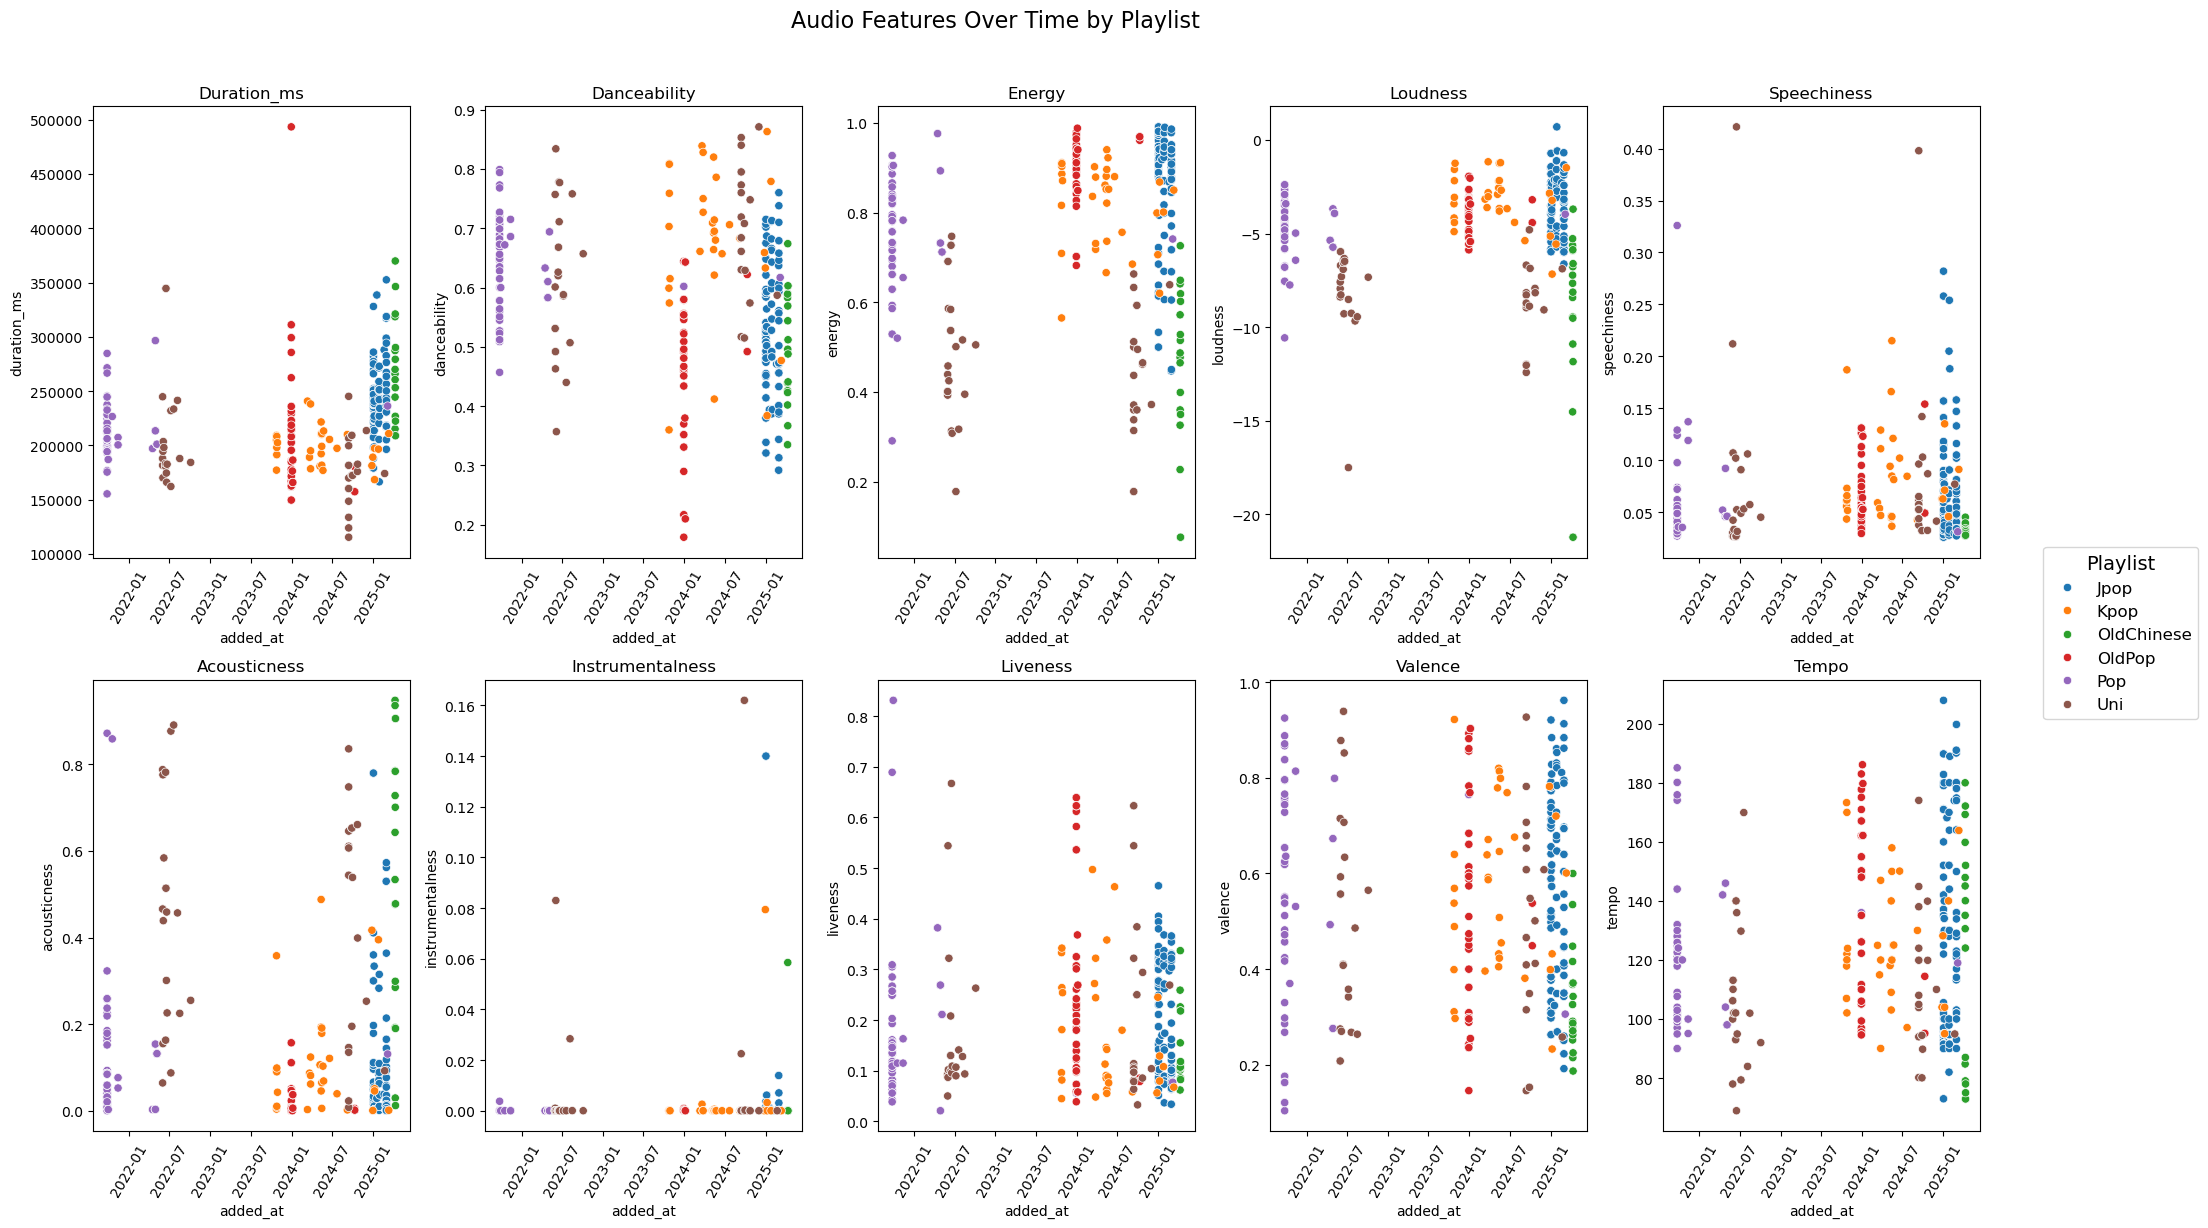

In [30]:
# set up subplot grid
n_rows = 2
n_cols = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
axes = axes.flatten()

# define colors for each playlist
playlist_order = sorted(df['playlist'].unique())
palette = sns.color_palette("tab10", n_colors = len(playlist_order))
palette_dict = dict(zip(playlist_order, palette))

# create scatterplots for each feature
for i, feature in enumerate(numeric_features):
    sns.scatterplot(
        data = df,
        x = 'added_at',
        y = feature,
        hue = 'playlist',
        hue_order = playlist_order,
        palette = palette_dict,
        ax = axes[i])
    axes[i].get_legend().remove()
    axes[i].set_title(feature.capitalize())
    axes[i].tick_params(axis = 'x', rotation = 60)

# remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# set a global legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title = 'Playlist', bbox_to_anchor=(1.02, 0.5), loc='center left', fontsize = 12, title_fontsize = 14)
plt.suptitle('Audio Features Over Time by Playlist', fontsize = 16, y = 1.02)
plt.tight_layout()
plt.show()

The above plot shows each audio feature for every song in my dataset, plotted against the date the song was added to my Spotify library. Each panel in the grid represents one feature (energy, danceability, acousticness, etc.), while the color indicates the playlist the song belongs to. The goal of this visualization is to uncover patterns in my listening habits and better understand the characteristics of the music I gravitated toward over the years.

***The location/color of each point doesn't really matter here, especially since these plots are so small (this was intended; readability was sacrificed so it was easier to see/compare general trends). Instead, focus on clusters of points and take a holisitc approach to each plot (please don't strain your eyes!).***

I tend to create playlists and add songs to them all at once, typically at the moment of the playlist’s creation. Each playlist reflects my emotional state at the time, and I often replay it until I move on to creating a new one. This behavior is clearly reflected in the scatterplots: songs cluster at distinct points in time rather than being added continuously, indicating that song additions happen in bursts.

The *Pop*, *Jpop*, and *Kpop* playlists all show high levels of energy, loudness, and danceability, with low values of acousticness and instrumentalness. These features align with more upbeat and energetic tracks. Based on the dates, these playlists were primarily created in early 2022 (*Pop*) and again in mid-to-late 2024 (*Kpop* and *Jpop*) and beyond, which coincidentally line up with when I was about to graduate and when I was accepted to my Master's program and beyond (both bright moments in my life).

In contrast, the *Uni* songs exhibit lower energy, loudness, liveness, and tempo, which suggest a softer, quieter, and more emotional listening experience. This aligns with the mental and emotional state I was in during that time while navigating post-grad unemployment and, thus, more introspection and complicated emotions.

Since it is now clear that songs were added in discrete batches, the actual date a song was added is less important than the playlist context itself. With this confirmation, a more effective way to compare audio characteristics across playlists would be through box plots, which allow for a cleaner, more focused comparison of distributions without relying on time as a dimension.

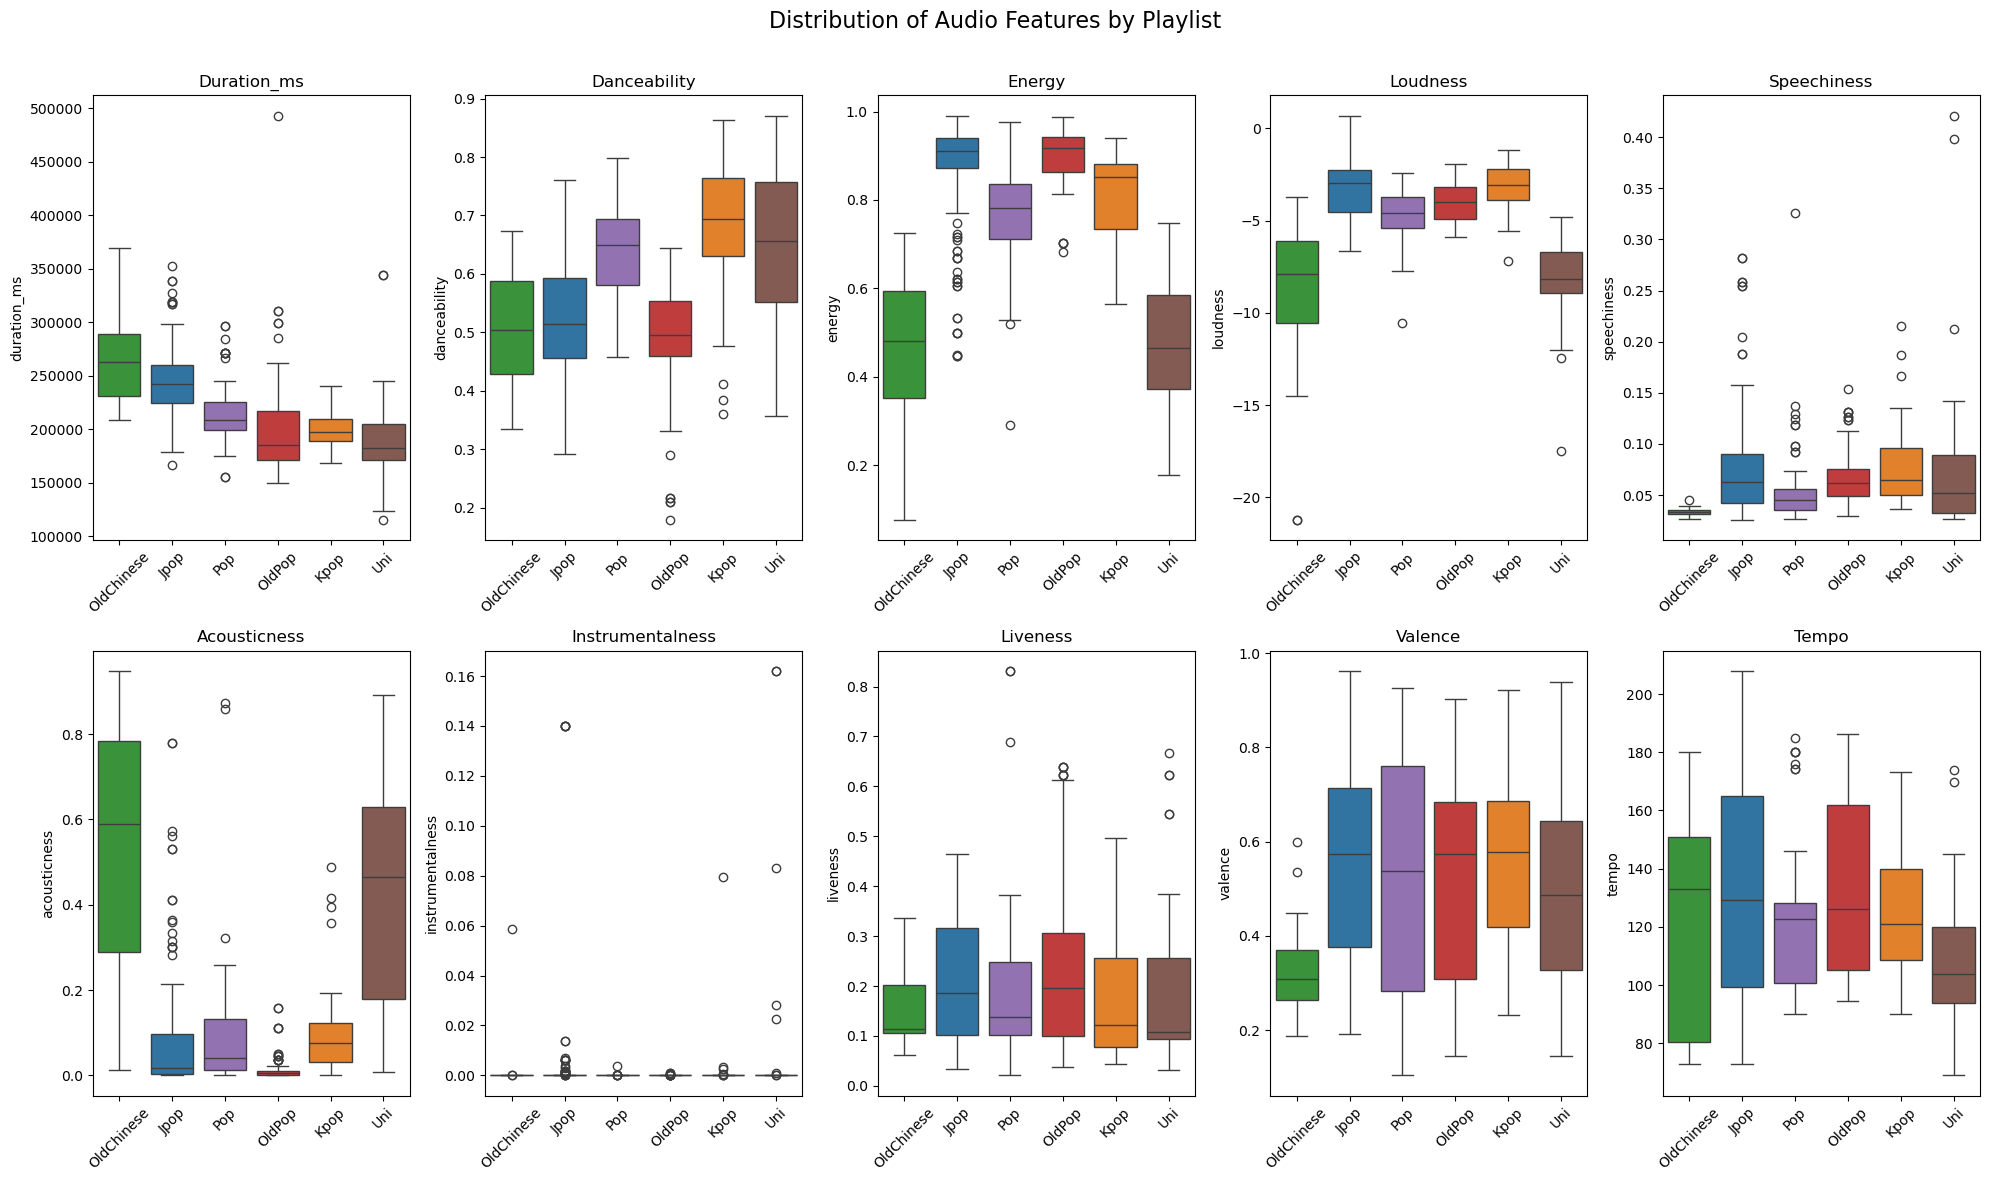

In [32]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
axes = axes.flatten()

# create boxplots for each feature
for i, feature in enumerate(numeric_features):
    sns.boxplot(data = df,
                x = 'playlist',
                y = feature,
                hue = 'playlist',
                hue_order = playlist_order,
                palette = palette_dict,
                ax = axes[i])
    axes[i].set_title(feature.capitalize())
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)


# adjust layout
plt.suptitle("Distribution of Audio Features by Playlist", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


The above plot provides a clearer summary of how audio features are distributed across each playlist, highlighting distinctions that were only partially visible in the scatterplots.

One of the most obvious patterns is the difference in energy levels between *OldChinese* and *Uni* against the other playlists, which are all modern pop. This makes sense as *Uni* (as mentioned before) was curated during a more emotionally difficult time and leans toward softer, more introspective tracks. This is in contrast to the pop playlists, which were built during happier periods and reflect brighter, more upbeat moods. This trend is echoed in loudness, where *Uni* and *OldChinese* feature noticeably quieter tracks compared to the louder, more modern pop mixes. A similar divide appears in acousticness, with *OldChinese* and *Uni* showing significantly higher values and wider spreads; in contrast, the pop playlists cluster around low acousticness values.

Interestingly, the boxplots also reveal patterns that were harder to spot in the scatterplots. For example, valence, a measure of musical positivity, is fairly consistent across all playlists, with the exception of *OldChinese*, which tends to be lower. This suggests I generally prefer songs with positive undertones regardless of mood. Tempo provides additional nuance: *OldChinese*, *Jpop*, and to some extent *Kpop* exhibit wider tempo distributions, suggesting a variety of pacing within those playlists. *Pop* and *Uni*, on the other hand, show more consistency and a smaller spread in tempo, indicating I prefer songs (or maybe the types of songs I generally chose in these playlists) more consistent in pace.

I want to stress this point: the audio features reflected by each playlist reinforce my emotional state at the time of creation (which was intended): *Uni*, created during a more stressful time, emphasizes softer, more emotionally resonant tracks, while the pop playlists are meant to energize and uplift. It is fascinating to see audio features align well with the intent of my playlists and shows how greatly mood can (consciously or unconsciously) influence musical preferences. That doesn't mean that I don't have music preferences, however. For instance, the consistently wider, but generally positive (around 0.5 or more), spread of each playlist for valence shows preference.

While visuals like boxplots and scatterplots are useful for revealing patterns and trends, they do leave room for interpretation. As such, we can compute the pairwise distances (a mathematical representation of their geometric distances) for each playlist using their audio features, which will allow me to move beyond visualization and, instead, measure similarity between playlists mathematically.

Before doing so, we should examine correlation to avoid redundancy (this will also be good for modeling later on as well).

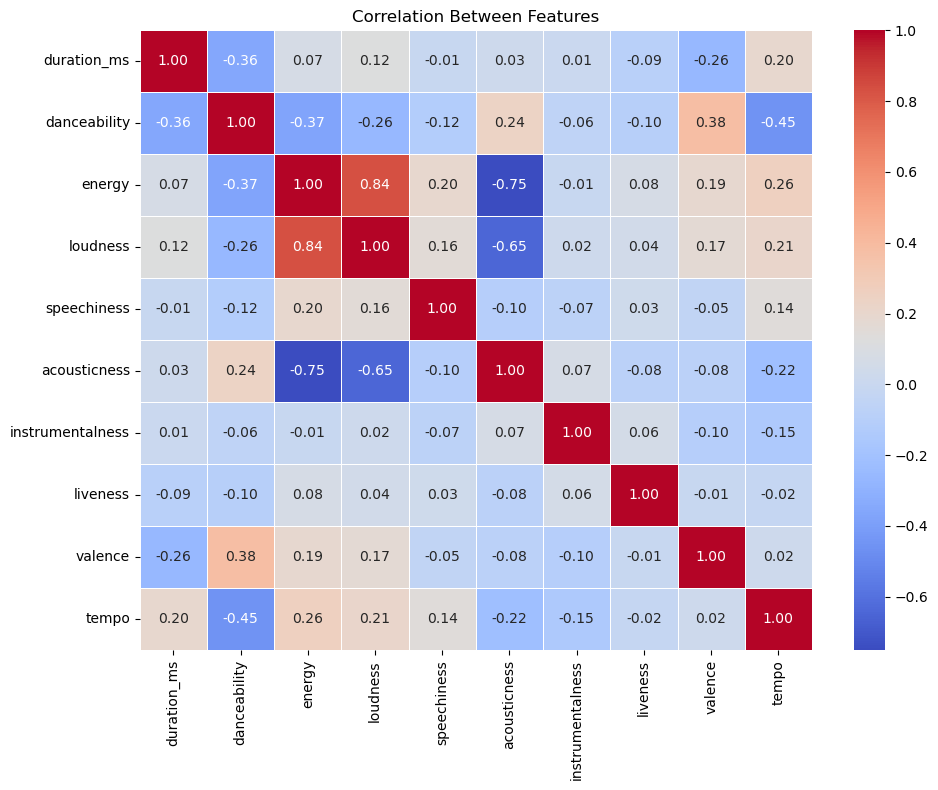

In [34]:
plt.figure(figsize = (10, 8))
sns.heatmap(df[numeric_features].corr(),
            annot = True,
            cmap = 'coolwarm',
            fmt = '.2f',
            linewidths = 0.5)
plt.title('Correlation Between Features')
plt.tight_layout()
plt.show()

The correlation heatmap shows 3 highly correlated features (energy, loudness, and acousticness). More specifically, energy and loudness are positively correlated while acousticness is negatively correlated with both. This suggests overlapping aspects of audio features and, as such, potential redundancies when modeling. For the purposes of computing pairwise distances between playlists, I've decided not to remove any of these features to preserve interpretability (at least for now). I *will*, however, apply standardization to the features at the cost of interpretability; this will make it so that when I compute pairwise distances, no feature will dominate distance calculations due to differences in scale.

To compute pairwise distances, I will compute the average of each feature for each playlist. I will then scale it and find compute the pairwise distances using the `pairwise_distance()` function from the sklearn library.

In [37]:
# find means of each playlist for each feature
feature_means = df.groupby('playlist')[numeric_features].mean()

In [38]:
# initialize scaler
scaler = StandardScaler()

In [39]:
# scale means of each playlist for each feature
feature_means_scaled = scaler.fit_transform(feature_means)

In [40]:
# compute pairwise distances
distance_matrix = pairwise_distances(feature_means_scaled, metric='l2')

In [41]:
# convert pairwise distances into pandas data frame for easy analysis
distance_df = pd.DataFrame(
    distance_matrix,
    index = feature_means.index,
    columns = feature_means.index
)

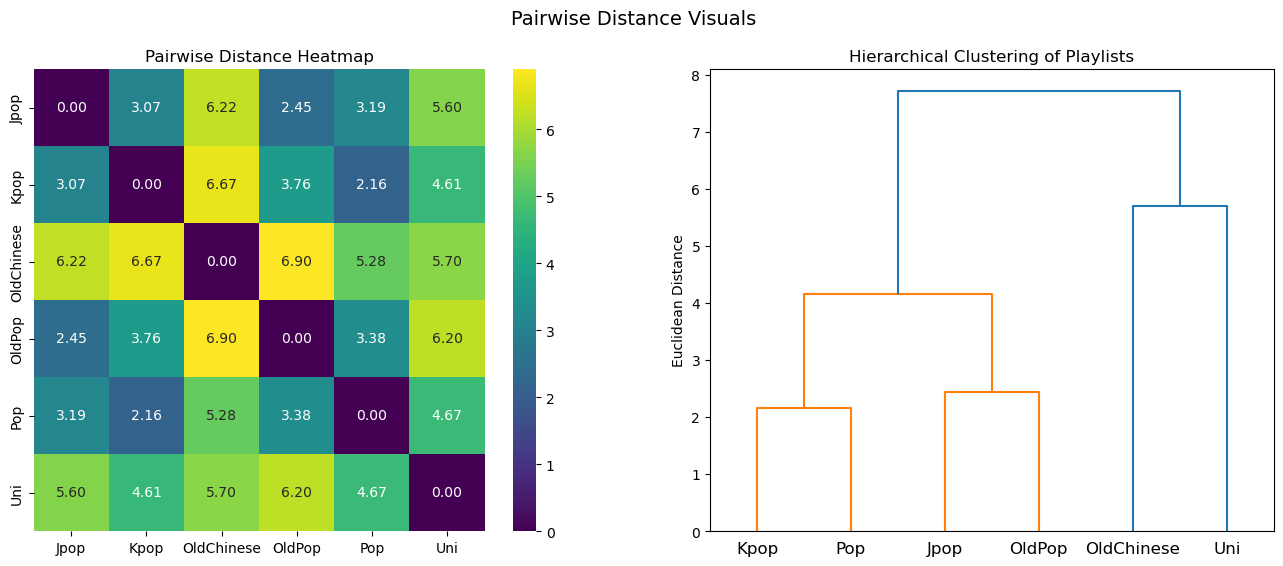

In [42]:
# create visualizations for the pairwise distances
playlists = feature_means.index.tolist()
linked = linkage(feature_means_scaled, method='ward')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

sns.heatmap(distance_matrix,
            xticklabels = playlists,
            yticklabels = playlists,
            cmap = 'viridis',
            fmt = '.2f',
            annot = True,
            ax = ax1)
ax1.set_title("Pairwise Distance Heatmap")

dendrogram(linked, 
           labels = playlists, 
           orientation = 'top',
           distance_sort = 'ascending',
           show_leaf_counts = True,
           ax = ax2)
ax2.set_title("Hierarchical Clustering of Playlists")
ax2.set_ylabel("Euclidean Distance")
plt.suptitle("Pairwise Distance Visuals", fontsize = 14)
plt.show()

The above plot allows us to see how similar my playlists are from each other. It shows two visuals that break down the pairwise distances nicely: a heatmap representing the Euclidean (L2) distances between each pair of playlists and a tree diagram (called a dendrogram) representing hierarhcical distance relationships between each playlist.

We start with the heatmap; the smaller distance, the more similar the two playlists are. For instance, *Kpop* and *Pop* have the lowest distance (2.16), suggesting these two playlists are the most similar. *OldChinese* and *OldPop* have the highest distance (6.90), with *OldChinese* and *KPop* (6.67) being a very close second. This implies these two pairs are the most dissimilar. Most notably, *Uni* is quite distant from other playlists; it is closest to *Pop* (4.67) and *Kpop* (4.61), suggesting modern pop influence, but this number is still high relative to other playlists.

The tree diagram, called a dendrogram, shows a hierarchical clustering (using Ward's method) of the playlists. Each vertical line (called a link) represents the merging of two clusters; the height at which the link occurs indicates the distance between the merged clusters. This means that the lower the linkage, the more similar the groups are.

Note how we see the results of the heatmap but in an easier-to-digest format. For instance, *OldPop*, *Jpop*, and *Kpop* are the most similar and *Uni* is the most distant from other playlists, shown by its placement in the dendrogram. Perhaps most interesting is the two clusters formed *OldPop*, *Jpop*, *Kpop*, and *Pop* in one cluster and *OldChinese* and *Uni* in another. Notice the *OldChinese* and *Uni* cluster merge close to the top of the tree, indicating that the cluster is vastly different from the other cluster (which merges farther down the tree).

Together, these visuals offer concrete, quantitative evidence supporting what was suggested from the scatterplots and boxplots: the pop playlists are tightly grouped and most similar whereas *OldChinese* and *Uni* are more distinct. It is also interesting to see my moods being reflected in a mathematical way; recall how I created the *Uni* playlist in more tumultuous times whereas the pop playlists were created in happier times. These clusters, represented by audio features, easily demonstrate the difference in my moods.

## Categorical Features

There are three categorical features in the dataset. Although not super interesting, for completeness, we should explore them as well. Let's start with a bar chart per playlist.

In [46]:
# define categorical features
categorical_features = ['key', 'mode', 'time_signature']

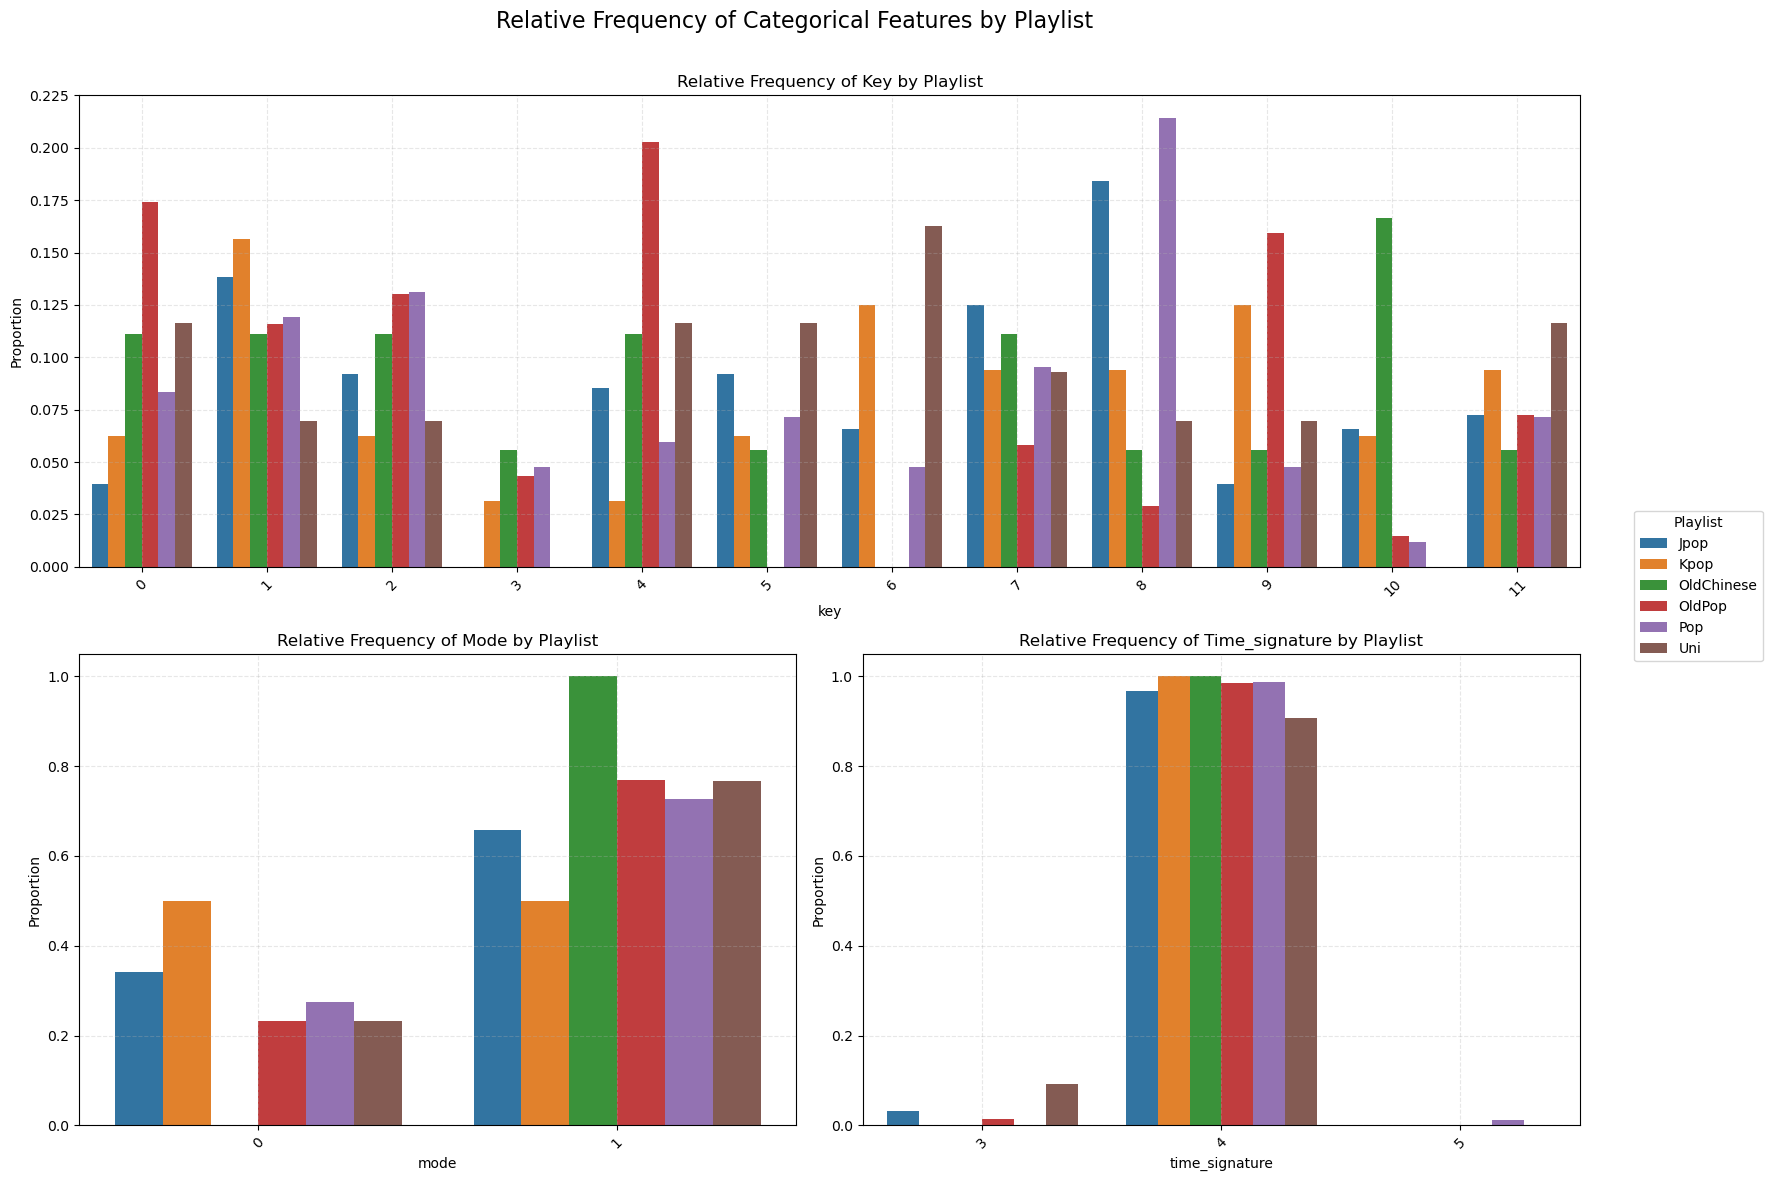

In [47]:
fig = plt.figure(figsize = (16, 12))
gs = fig.add_gridspec(2, 2) 

axes = [
    fig.add_subplot(gs[0, :]),  # top row
    fig.add_subplot(gs[1, 0]),  # bottom left
    fig.add_subplot(gs[1, 1])   # bottom right
]

for i, feature in enumerate(categorical_features):
    counts = df.groupby(['playlist', feature]).size()
    proportions = counts.groupby(level = 0).transform(lambda x: x / x.sum())
    prop_df = proportions.reset_index(name='proportion')

    sns.barplot(
        data = prop_df,
        x = feature,
        y = 'proportion',
        hue = 'playlist',
        hue_order = playlist_order,
        palette = palette_dict,
        ax = axes[i])
    axes[i].set_title(f'Relative Frequency of {feature.capitalize()} by Playlist')
    axes[i].tick_params(axis = 'x', rotation = 45)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Proportion')
    axes[i].grid(True, linestyle='--', alpha = 0.3)
    axes[i].get_legend().remove()
    

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title = 'Playlist', bbox_to_anchor = (1.02, 0.5), loc = 'center left')

plt.suptitle("Relative Frequency of Categorical Features by Playlist", fontsize = 16)
plt.tight_layout(rect = [0, 0, 1, 0.97])
plt.show()

The above plots show relative frequencies of each categorical variable. 

**Key**

Focusing on each playlist by comparing colors, notice how keys are spread randomly. For instance, The *Pop* playlist has a relatively low 3rd key, high 8th, low 9th, and so on. *Uni* shows a high 6th key but relatively low on the 8th and 9th key (and doesn't even have any songs in the 10th key). Interestingly enough, key 3 seems low amongst all playlists. However, it is unclear which key dominates in each playlist. This feature seems incredibly diverse.

This chart implies that my general music tastes vary in terms of key.

**Mode**

Note the larger percentage of songs in major key (mode 1) than minor. This implies the majority of my playlists, across the board, generally sound brighter or happier, as many are in major key. Note, however, there are some playlists more balanced than others (for instance, *Kpop* is balanced exactly the same).

This chart implies that my playlists gravitate toward happier and brighter-sounding tracks.

**Time Signature**

Almost all songs in every playlist is in the 4th time signature. This makes sense, as most songs are in 4/4 anyway.

# Data Modeling

With some data analysis done, we should move onto modeling. As a reminder, the goal of this project is to determine if there is a discernable difference between my playlists.

The data analysis has basically answered my question (yes, there is a difference visually and geometrically). That being said, modeling will provide even more evidence to this claim if a machine can reliably predict which song belongs in which playlist. Modeling can also provide more insight; for instance, by using plotting feature importance from a Random Forest algorithm, we can determine which audio features were most useful in determining which song belonged to which playlist. Here will be the general outline:

1) Perform data preprocessing.

2) Split the data into training and testing sets.

3) Create a baseline.

4) Model and assess model performance.

5) Improve model and assess performance.

6) Attempt another model.

### Data Preprocessing

In [52]:
# ensure data types are correct for each variable (note how the categorical features are numeric; this is fine)
df[['playlist'] + list(all_features)].dtypes

playlist             object
duration_ms           int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
dtype: object

Here, we will build a preprocessing pipeline to deal with the audio features.

In [54]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop = 'first', handle_unknown = 'ignore'), categorical_features)
    ]
)

### Data Split

In [56]:
X = df[all_features]

In [57]:
y = df['playlist']

In [58]:
# set random seed for reproducibility
np.random.seed(0)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Create a baseline

We start with a dummy classifier, which uses majority ruling (extremely simple). We want final models to perform significantly better than the baseline.

In [62]:
baseline = DummyClassifier(strategy = 'most_frequent')

In [63]:
baseline.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [64]:
y_pred_base = baseline.predict(X_test)

In [65]:
print('Baseline Accuracy: ', accuracy_score(y_test, y_pred_base))

Baseline Accuracy:  0.375


The baseline accuracy is 37.5%. This means that as long as the final model surpasses an accuracy score of 37.5%, there will be reason to believe the model is learning patterns and does better than simple guessing.

Alternatively, we can use a more advanced method (but still quite simple) to assess the results of the final model. For instance, a logistic regression model can work.

Before modeling (especially for logistic regression), it's important to note the imbalanced nature of the data.

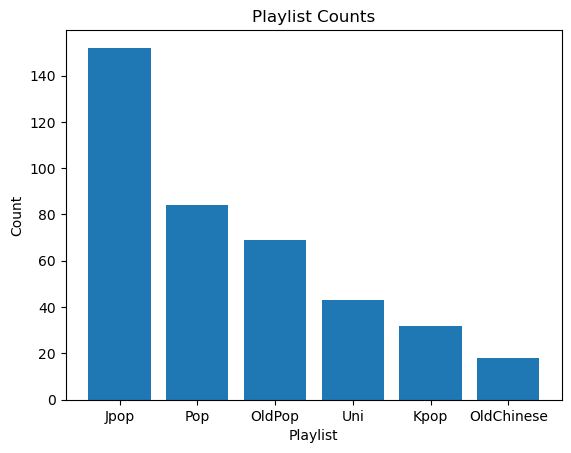

In [68]:
plt.bar(y.value_counts().index, y.value_counts())
plt.title('Playlist Counts')
plt.xlabel('Playlist')
plt.ylabel('Count')
plt.show()

Imbalanced data has a large issue in the context of modeling because it skews performance and is biased toward majority classes.

1) When training, models optimize by minimizing overall error; as such, minority classes (in this case *OldChinese* and even *Kpop*) are favored less. This is especially problematic when missing a rare category (that is, by nature, already underrepresented in populations) can be costly (like fraud detection or medical diagnosis).

2) With a small number of samples, minority classes are poorlty generalized. This causes overfitting in that class (i.e. it memorizes noise specific to the classes with a lower number of observations).

These challenges address why class imbalance is crucial to keep in mind: predictions become less accurate not necessarily because features are less distinguishable but primarily due to an imbalance in sample representation.

To resolve this issue, we will pass the parameter `class_weight = 'balanced'` into the models.

In [71]:
log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight = 'balanced', max_iter = 1000))
])

In [72]:
log_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['key', 'mode',
                                                   'time_signature'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [73]:
y_pred_log_reg = log_reg_pipeline.predict(X_test)

In [74]:
accuracy_score(y_test, y_pred_log_reg)

0.65

The true baseline we want to hit is 65% (since the majority class was such a low bar).

### Model and Assess Model Performance

In [77]:
# initialize main model pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight = 'balanced', random_state = 42))
])

In [78]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['key', 'mode',
                                                   'time_signature'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [79]:
y_pred_rf = rf_pipeline.predict(X_test)

In [80]:
# define function to show results
def display_cm(predictions, pipeline, y_test = y_test):
    # show accuracy score
    print(f'Accuracy Score: {accuracy_score(y_test, predictions)}')
    
    cm = confusion_matrix(y_test, predictions, normalize = 'true')
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = pipeline.classes_)
    disp.plot()
    plt.title(f'Confusion Matrix')
    plt.show()

Accuracy Score: 0.7375


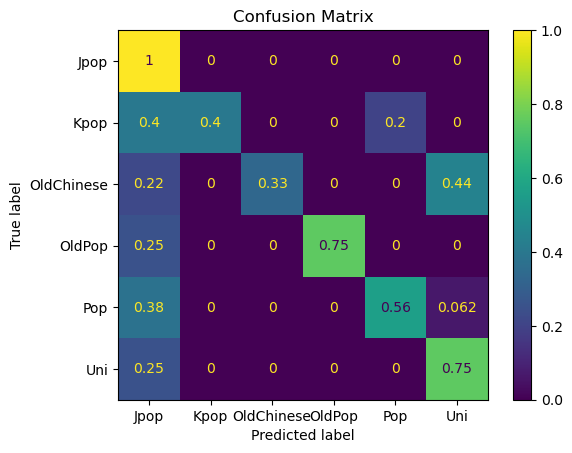

In [81]:
display_cm(predictions = y_pred_rf, pipeline = rf_pipeline)

The accuracy score from the Random Forest model is 73.75%, which is slightly better than logistic regression. However, there are things that can improve the performance and complexity of the model. We can start with a feature importance plot to determine which audio features are most useful.

In [83]:
ohe_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

In [84]:
feature_names = list(numeric_features) + list(ohe_features)

In [85]:
importances = rf_pipeline.named_steps['classifier'].feature_importances_

In [86]:
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

In [87]:
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

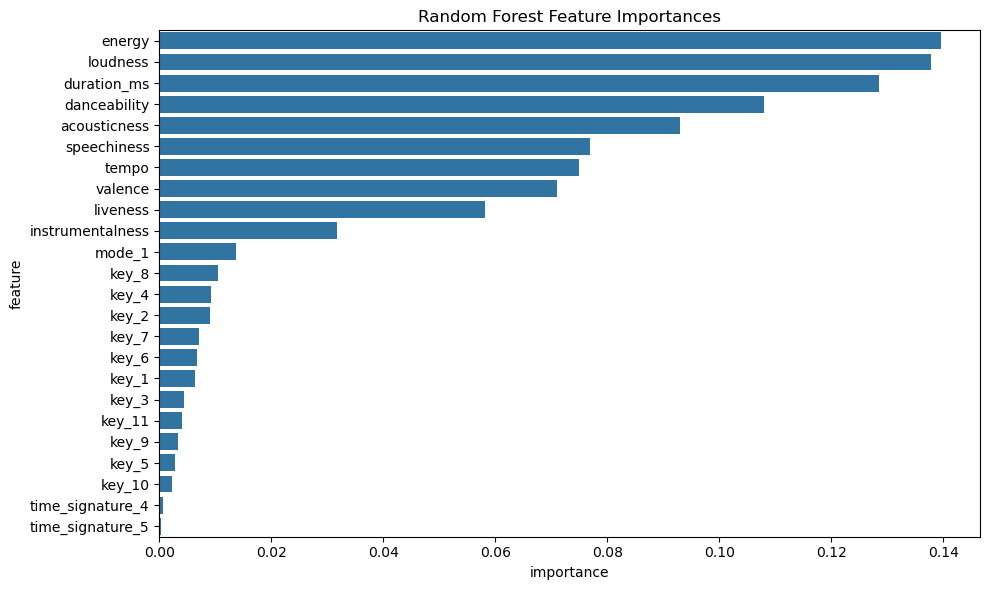

In [88]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp_df)
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()

According to the above plot, `energy` is the most important. `Loudness` is a close second. This may suggest my playlists are most distinct in terms of these factors (which makes sense, especially for *Uni* vs the pop playlists). 

To reduce complexity, I am curious what would happen if I deleted the `time_signature` variable. Removing this variable may not matter too much in terms of accuracy and will help reduce complexity and improve interpretability.

### Improve Model and Assess Performance

In [91]:
##### build function to create rf pipeline for continuous testing
def build_rf_pipeline(numeric_features, categorical_features, dropped_cols = None):

    if dropped_cols is None:
        dropped_cols = []
    
    # filter features to remove dropped columns
    numeric_features_dropped = [col for col in numeric_features if col not in dropped_cols]
    categorical_features_dropped = [col for col in categorical_features if col not in dropped_cols]
    
    # build preprocessor with updated numeric features
    preprocessor_dropped = ColumnTransformer(
        transformers = [
            ('num', StandardScaler(), numeric_features_dropped),
            ('cat', OneHotEncoder(drop = 'first', handle_unknown = 'ignore'), categorical_features_dropped)
        ]
    )
    
    # dropper transformer to remove unwanted columns from input dataframe
    dropper = FunctionTransformer(lambda df: df.drop(dropped_cols, axis = 1), validate = False)
    
    # build pipeline
    pipeline = Pipeline([
        ('drop', dropper),
        ('preprocessor', preprocessor_dropped),
        ('classifier', RandomForestClassifier(class_weight = 'balanced', random_state = 42))
    ])

    return pipeline, numeric_features_dropped, categorical_features_dropped

In [92]:
### build function to train rf for continuous testing
def train_rf_with_dropped_features(X_train, y_train, X_test, y_test, numeric_features, categorical_features, dropped_cols = [None]):
    # build pipeline
    pipeline, numeric_features_dropped, categorical_features_dropped = build_rf_pipeline(numeric_features, categorical_features, dropped_cols)

     # fit model
    pipeline.fit(X_train, y_train)
    
    # predict on test data
    y_pred = pipeline.predict(X_test)
    
    # display confusion matrix
    display_cm(predictions = y_pred, pipeline = pipeline, y_test = y_test)
    
    # extract feature names for feature importance plot
    preprocessor_dropped = pipeline.named_steps['preprocessor']
    ohe_features = preprocessor_dropped.named_transformers_['cat'].get_feature_names_out(categorical_features_dropped)
    feature_names = list(numeric_features_dropped) + list(ohe_features)
    
    # extract feature importances from classifier
    importances = pipeline.named_steps['classifier'].feature_importances_
    
    # prep dataframe for plotting
    feat_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by = 'importance', ascending = False)
    
    # plot feature importances
    plt.figure(figsize = (10, 6))
    sns.barplot(x = 'importance', y = 'feature', data = feat_imp_df)
    plt.title('Random Forest Feature Importances (Dropped Columns)')
    plt.tight_layout()
    plt.show()
    
    return pipeline, feat_imp_df

Accuracy Score: 0.7625


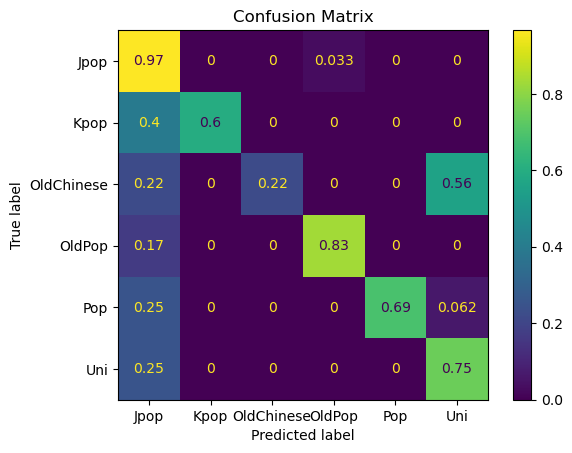

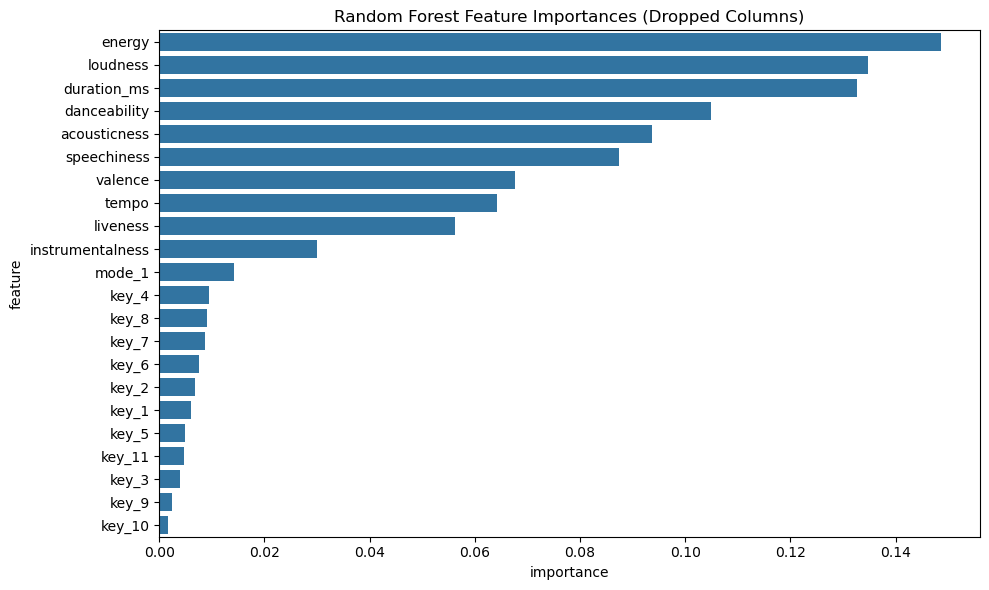

In [93]:
rf_pipeline, feat_imp_df = train_rf_with_dropped_features(
    X_train, y_train, X_test, y_test,
    numeric_features, categorical_features,
    dropped_cols = ['time_signature']
)

Key also makes the model quite complicated. It does not seem too important either, so what happens if we remove the variable from the model as well?

Accuracy Score: 0.7625


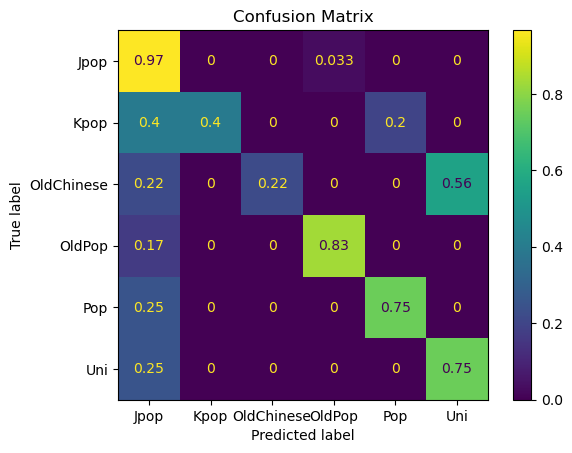

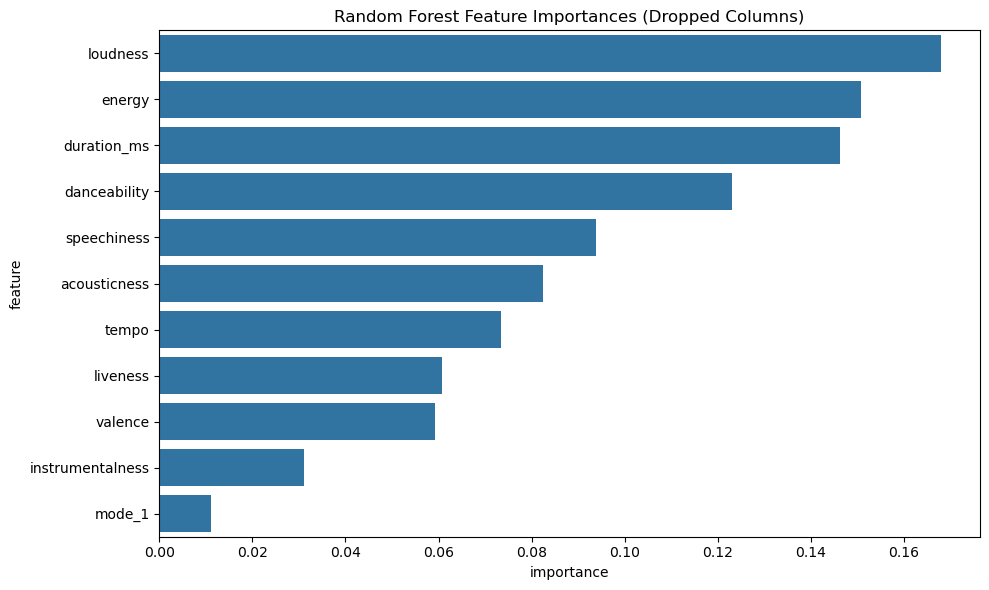

In [95]:
rf_pipeline, feat_imp_df = train_rf_with_dropped_features(
    X_train, y_train, X_test, y_test,
    numeric_features, categorical_features,
    dropped_cols = ['time_signature', 'key']
)

Note this accuracy is the same as the previous model, but is much simpler because of the removal of the key variable.

We now assess the performance of the model using cross validation. How well does the model actually perform?

In [96]:
def cv_rf_pipeline(X, y, numeric_features, categorical_features, dropped_cols = None, cv = 5, scoring = 'accuracy'):
    if dropped_cols is None:
        dropped_cols = []
    
    # build pipeline with dropped columns
    pipeline, _, _ = build_rf_pipeline(numeric_features, categorical_features, dropped_cols)
    
    # use StratifiedKFold for balanced splits on classification
    skf = StratifiedKFold(n_splits = cv, shuffle = True, random_state = 42)
    
    # run cross-validation
    scores = cross_val_score(pipeline, X, y, cv = skf, scoring = scoring)
    
    # print summary
    print(f"Dropped columns: {dropped_cols}")
    print(f"CV {scoring}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    
    # return full fold scores for further analysis
    return scores

In [97]:
cv_rf_pipeline(X, y, numeric_features, categorical_features, dropped_cols = [])

C:\Users\chui2\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Dropped columns: []
CV accuracy: 0.8443 ± 0.0336


array([0.825     , 0.875     , 0.7875    , 0.86075949, 0.87341772])

In [98]:
cv_rf_pipeline(X, y, numeric_features, categorical_features, dropped_cols = ['time_signature'])

Dropped columns: ['time_signature']
CV accuracy: 0.8419 ± 0.0316


array([0.8125    , 0.85      , 0.8       , 0.88607595, 0.86075949])

In [99]:
cv_rf_pipeline(X, y, numeric_features, categorical_features, dropped_cols = ['time_signature', 'key'])

Dropped columns: ['time_signature', 'key']
CV accuracy: 0.8368 ± 0.0408


array([0.8375    , 0.875     , 0.7625    , 0.87341772, 0.83544304])

Interestingly, the cross validation scores are higher than the original train/test split accuracy scores. This score is so high it makes me skeptical, but I cannot seem to find any part of my code that will allow for data leakage. As such, **please take this high accuracy score with a grain of salt and note there may be a problem with the code/my statistics**.

These high scores indicate that songs can be placed in the correct playlist with a pretty good average rating (around 83%). This, along with the data analysis and geometrical distance analysis previously, leaves us with a strong reason to believe that **my playlists are very easy to distinguish between each other**. A couple of important audio features in distinguishing these 